In [1]:
import os
import sys

# Method 1: Using os.chdir()
os.chdir('/datasets/_deepnote_work/ClearBias')
sys.path.append('/datasets/_deepnote_work/ClearBias')

# To verify current directory
current_dir = os.getcwd()
print(current_dir)
print(sys.path)

/datasets/_deepnote_work/ClearBias
['/', '/shared-libs/python3.9/py-core/lib/python3.9/site-packages', '/', '/usr/local/lib/python39.zip', '/usr/local/lib/python3.9', '/usr/local/lib/python3.9/lib-dynload', '/root/venv/lib/python3.9/site-packages', '/usr/local/lib/python3.9/site-packages', '/shared-libs/python3.9/py/lib/python3.9/site-packages', '/root/work/ClearBias/data_generator', '/datasets/_deepnote_work/ClearBias']


In [5]:
from ucimlrepo import fetch_ucirepo
from dataclasses import dataclass
from typing import List, Tuple, Dict, Union
import pandas as pd
import numpy as np
from scipy.stats import spearmanr, gaussian_kde
from data_generator.main import generate_data
from sklearn.preprocessing import LabelEncoder


def is_numeric_column(series: pd.Series) -> bool:
    """
    Check if a column should be treated as numeric for KDE.
    """
    if not np.issubdtype(series.dtype, np.number):
        return False

    n_unique = len(series.dropna().unique())
    return n_unique >= 5


def is_integer_column(series: pd.Series) -> bool:
    """
    Check if a numeric column contains only integers.
    """
    return np.all(series.dropna() == series.dropna().astype(int))


def get_unique_samples(kde: gaussian_kde, n_samples: int, is_integer: bool = False,
                       max_attempts: int = 1000) -> np.ndarray:
    """
    Get unique samples from KDE with appropriate type handling.
    """
    samples = kde.resample(min(n_samples * 2, max_attempts))[0]

    if is_integer:
        samples = np.round(samples).astype(int)

    unique_samples = np.unique(samples)

    attempts = 1
    while len(unique_samples) < n_samples and attempts < max_attempts:
        new_samples = kde.resample(n_samples)[0]
        if is_integer:
            new_samples = np.round(new_samples).astype(int)
        unique_samples = np.unique(np.concatenate([unique_samples, new_samples]))
        attempts += 1

    if len(unique_samples) > n_samples:
        indices = np.linspace(0, len(unique_samples) - 1, n_samples).astype(int)
        unique_samples = np.sort(unique_samples)[indices]

    return unique_samples


@dataclass
class DataSchema:
    attr_categories: List[List[Union[int, float]]]  # Now starts from 0
    protected_attr: List[str]
    attr_names: List[str]
    category_maps: Dict[str, Dict[Union[int, float], str]]


def create_kde_encoding(series: pd.Series, n_samples: int = 100) -> Tuple[
    np.ndarray, gaussian_kde, List[Union[int, float]], Dict[Union[int, float], str]]:
    """
    Create KDE from the series and sample fixed points from it.
    """
    non_nan_mask = pd.notna(series)
    values = series[non_nan_mask].to_numpy()

    if len(values) == 0:
        return np.full(len(series), -1), None, [-1, 0], {-1: 'nan', 0: '0'}

    kde = gaussian_kde(values)
    is_integer = is_integer_column(series)
    sampled_points = get_unique_samples(kde, n_samples, is_integer)

    # Create categories starting from -1 (missing) then 0 to n-1
    categories = [-1] + list(range(len(sampled_points)))

    # Create mapping dictionary
    if is_integer:
        category_map = {-1: 'nan',
                        **{i: str(int(point)) for i, point in zip(range(len(sampled_points)), sampled_points)}}
    else:
        category_map = {-1: 'nan',
                        **{i: f"{point:.3f}" for i, point in zip(range(len(sampled_points)), sampled_points)}}

    # Encode original values
    encoded = np.full(len(series), -1)  # Default to -1 for missing values
    for i, val in enumerate(series[non_nan_mask]):
        nearest_idx = np.abs(sampled_points - val).argmin()
        encoded[non_nan_mask][i] = nearest_idx  # Now starts from 0

    return encoded, kde, categories, category_map


def generate_schema_from_dataframe(
        df: pd.DataFrame,
        protected_columns: List[str] = None,
        attr_prefix: str = None,
        outcome_column: str = 'outcome',
        ensure_positive_definite: bool = True,
        n_samples: int = 100
) -> Tuple[DataSchema, np.ndarray]:
    """
    Generate a DataSchema and correlation matrix from a pandas DataFrame using KDE for numeric columns.
    """
    if outcome_column not in df.columns:
        raise ValueError(f"Outcome column '{outcome_column}' not found in DataFrame")

    if attr_prefix:
        attr_columns = [col for col in df.columns if col.startswith(attr_prefix)]
    else:
        attr_columns = [col for col in df.columns if col != outcome_column]

    if not attr_columns:
        raise ValueError("No attribute columns found")

    attr_categories = []
    encoded_df = pd.DataFrame(index=df.index)
    binning_info = {}
    kde_distributions = {}
    label_encoders = {}
    category_maps = {}

    for col in attr_columns:
        if is_numeric_column(df[col]):
            encoded_vals, kde, categories, category_map = create_kde_encoding(df[col], n_samples)

            encoded_df[col] = encoded_vals
            attr_categories.append(categories)  # Now contains [-1, 0, 1, ..., n-1]
            category_maps[col] = category_map

            if kde is not None:
                kde_distributions[col] = kde
                binning_info[col] = {
                    'strategy': 'kde',
                    'n_samples': n_samples,
                    'is_integer': is_integer_column(df[col])
                }

        else:
            le = LabelEncoder()
            non_nan_vals = df[col].dropna().unique()

            if len(non_nan_vals) > 0:
                str_vals = [str(x) for x in non_nan_vals]
                str_vals = list(dict.fromkeys(str_vals))

                le.fit(str_vals)
                encoded = np.full(len(df), -1)  # Default to -1 for missing values

                mask = df[col].notna()
                if mask.any():
                    encoded[mask] = le.transform([str(x) for x in df[col][mask]])  # Now starts from 0

                # Store encoded categories and mapping
                categories = [-1] + list(range(len(str_vals)))  # [-1, 0, 1, ..., n-1]
                category_map = {-1: 'nan', **{i: val for i, val in enumerate(str_vals)}}

                label_encoders[col] = le
                category_maps[col] = category_map
            else:
                encoded = np.full(len(df), -1)
                categories = [-1, 0]  # Always include 0 even if empty
                category_map = {-1: 'nan', 0: 'empty'}

            encoded_df[col] = encoded
            attr_categories.append(categories)

    # Rest of the function remains the same...
    if protected_columns is None:
        protected_attr = [False] * len(attr_columns)
    else:
        invalid_cols = [col for col in protected_columns if col not in attr_columns]
        if invalid_cols:
            raise ValueError(f"Protected columns {invalid_cols} not found in attributes")
        protected_attr = [col in protected_columns for col in attr_columns]

    correlation_matrix = np.zeros((len(attr_columns), len(attr_columns)))
    for i, col1 in enumerate(attr_columns):
        for j, col2 in enumerate(attr_columns):
            if i == j:
                correlation_matrix[i, j] = 1.0
            else:
                # Update mask to check for non-zero values
                mask = (encoded_df[col1] > 0) & (encoded_df[col2] > 0)
                if mask.any():
                    corr, _ = spearmanr(encoded_df[col1][mask], encoded_df[col2][mask])
                    correlation_matrix[i, j] = corr if not np.isnan(corr) else 0.0
                    correlation_matrix[j, i] = correlation_matrix[i, j]
                else:
                    correlation_matrix[i, j] = 0.0
                    correlation_matrix[j, i] = 0.0

    if ensure_positive_definite:
        eigenvalues, eigenvectors = np.linalg.eigh(correlation_matrix)
        if np.any(eigenvalues < 0):
            eigenvalues[eigenvalues < 0] = 1e-6
            correlation_matrix = eigenvectors @ np.diag(eigenvalues) @ eigenvectors.T
            scaling = np.sqrt(np.diag(correlation_matrix))
            correlation_matrix = correlation_matrix / scaling[:, None] / scaling[None, :]

    schema = DataSchema(
        attr_categories=attr_categories,
        protected_attr=protected_attr,
        attr_names=attr_columns,
        category_maps=category_maps
    )

    return schema, correlation_matrix


def decode_dataframe(df: pd.DataFrame, schema: DataSchema) -> pd.DataFrame:
    """
    Decode a dataframe using the schema's category maps.
    """
    decoded_df = pd.DataFrame(index=df.index)

    for col in schema.attr_names:
        if col in df.columns:
            category_map = schema.category_maps[col]
            decoded_df[col] = df[col].map(lambda x: category_map.get(x, category_map[0]))

    return decoded_df


/shared-libs/python3.9/py/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def is_numeric_column(series):
    try:
        pd.to_numeric(series)
        return len(series.unique()) > 10
    except:
        return False

def plot_distributions_comparison(df1, df2, figsize=(30, 25), max_categories=20):
    # Find shared columns
    shared_columns = list(set(df1.columns) & set(df2.columns))
    if not shared_columns:
        raise ValueError("No shared columns found between the dataframes")
    
    # Calculate number of rows for subplots (one row per shared column)
    n_rows = len(shared_columns)
    n_cols = 2  # Two columns: one for each dataframe
    
    # Create figure and subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    fig.suptitle('Distribution Comparison by Column', fontsize=16, y=1.02)
    
    # If there's only one shared column, wrap axes in a 2D array
    if n_rows == 1:
        axes = np.array([axes])
    
    for idx, column in enumerate(shared_columns):
        is_numeric = is_numeric_column(df1[column]) or is_numeric_column(df2[column])
        
        if is_numeric:
            # Handle numeric columns
            for df_idx, (df, ax) in enumerate([(df1, axes[idx, 0]), (df2, axes[idx, 1])]):
                numeric_data = pd.to_numeric(df[column])
                
                sns.kdeplot(data=numeric_data.dropna(), ax=ax, fill=True)
                ax.set_title(f'{column} Distribution (DF {df_idx + 1})', pad=20)
                
                # Add basic statistics
                mean_val = numeric_data.mean()
                median_val = numeric_data.median()
                std_val = numeric_data.std()
                
                stats_text = f'Mean: {mean_val:.2f}\nMedian: {median_val:.2f}\nStd: {std_val:.2f}'
                ax.text(0.95, 0.95, stats_text,
                       transform=ax.transAxes,
                       verticalalignment='top',
                       horizontalalignment='right',
                       bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
        else:
            # Get all unique categories from both dataframes for this column and sort them
            all_categories = pd.Series(sorted(set(df1[column].dropna().astype(str)) | 
                                           set(df2[column].dropna().astype(str))))
            
            # Handle categorical columns
            for df_idx, (df, ax) in enumerate([(df1, axes[idx, 0]), (df2, axes[idx, 1])]):
                series_str = df[column].astype(str)
                series_str = series_str.replace('nan', 'NA')
                
                # Get value counts
                value_counts = series_str.value_counts()
                
                # Create a Series with all categories (filled with 0s)
                plot_data = pd.Series(0, index=all_categories)
                # Update with actual counts
                plot_data.update(value_counts)
                
                # Limit categories if needed
                if len(plot_data) > max_categories:
                    # Sort by frequency to find top categories
                    sorted_data = plot_data.sort_values(ascending=False)
                    top_cats = sorted_data.head(max_categories-1).index
                    
                    # Calculate sum of other categories
                    other_sum = sorted_data[max_categories-1:].sum()
                    
                    # Create new plot data with top categories (keeping alphabetical order)
                    plot_data = pd.Series(sorted_data[top_cats], index=sorted(top_cats))
                    plot_data['Other'] = other_sum
                
                # Create bar plot
                sns.barplot(x=plot_data.index, y=plot_data.values, ax=ax)
                ax.set_title(f'{column} Distribution (DF {df_idx + 1})', pad=20)
                
                # Improve x-axis label readability
                ax.tick_params(axis='x', rotation=45)
                ax.set_xticklabels(ax.get_xticklabels(), horizontalalignment='right')
                ax.margins(x=0.1)
                
                # Add value labels
                for i, v in enumerate(plot_data.values):
                    if v > 0:
                        ax.text(i, v, str(int(v)), 
                               horizontalalignment='center',
                               verticalalignment='bottom')
                
                # Add percentage labels
                total = plot_data.sum()
                percentages = (plot_data / total * 100).round(1)
                ax.set_ylabel('Count')
                
                for i, (count, percentage) in enumerate(zip(plot_data, percentages)):
                    if count > 0:
                        ax.text(i, count/2, f'{percentage}%',
                               horizontalalignment='center',
                               verticalalignment='center',
                               color='white',
                               fontweight='bold')
    
    # Adjust layout
    plt.tight_layout(h_pad=1.0, w_pad=0.5)
    return fig, shared_columns

In [14]:
from matplotlib.colors import LinearSegmentedColormap
from scipy.spatial.distance import cosine

def plot_correlation_matrices(input_correlation_matrix, gen_data, figsize=(30, 10)):
    attr_columns = [col for col in gen_data.dataframe.columns if col in list(df1.columns)]
    generated_correlation_matrix = gen_data.dataframe[attr_columns].corr(method='spearman')
    
    assert input_correlation_matrix.shape == generated_correlation_matrix.shape, "Correlation matrices have different shapes"
    
    if isinstance(input_correlation_matrix, np.ndarray):
        input_correlation_matrix = pd.DataFrame(input_correlation_matrix, columns=attr_columns, index=attr_columns)
    
    # Calculate similarity metrics
    frobenius = np.linalg.norm(input_correlation_matrix - generated_correlation_matrix)
    cosine_sim = 1 - cosine(input_correlation_matrix.values.flatten(), 
                           generated_correlation_matrix.values.flatten())
    mse = np.mean((input_correlation_matrix - generated_correlation_matrix) ** 2)
    correlation = np.corrcoef(input_correlation_matrix.values.flatten(), 
                            generated_correlation_matrix.values.flatten())[0,1]
    
    # Calculate the absolute difference matrix
    abs_diff_matrix = np.abs(input_correlation_matrix - generated_correlation_matrix)
    
    # Create custom colormap
    colors = ['#053061', '#2166AC', '#4393C3', '#92C5DE', '#D1E5F0', '#FDDBC7', '#F4A582', '#D6604D', '#B2182B']
    n_bins = 256
    custom_cmap = LinearSegmentedColormap.from_list('custom_blue_red', colors, N=n_bins)
    
    # Create figure with subplots
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=figsize)
    
    def plot_heatmap(data, ax, title, cmap='coolwarm', vmin=-1, vmax=1):
        sns.heatmap(data, ax=ax, cmap=cmap, vmin=vmin, vmax=vmax, center=0,
                    annot=True, fmt='.2f', square=True, cbar=False,
                    annot_kws={'size': 11}, linewidths=0.5)
        ax.set_title(title, fontsize=16, pad=20)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=11)
        ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=11)
    
    # Plot matrices
    plot_heatmap(input_correlation_matrix, ax1, 'Input Correlation Matrix')
    plot_heatmap(generated_correlation_matrix, ax2, 'Generated Data Correlation Matrix')
    plot_heatmap(abs_diff_matrix, ax3, 'Absolute Difference Matrix', cmap=custom_cmap, vmin=0, vmax=1)
    
    # Add colorbar
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    sm = plt.cm.ScalarMappable(cmap=custom_cmap, norm=plt.Normalize(0, 1))
    sm.set_array([])
    cbar = fig.colorbar(sm, cax=cbar_ax)
    cbar.ax.tick_params(labelsize=10)
    
    # Adjust layout and display
    plt.tight_layout(rect=[0, 0, 0.92, 1])
    plt.show()
    
    # Print all similarity metrics
    print("\nMatrix Similarity Metrics:")
    print(f"Mean absolute difference: {np.mean(abs_diff_matrix):.4f}")
    print(f"Maximum absolute difference: {np.max(abs_diff_matrix):.4f}")
    print(f"Frobenius norm: {frobenius:.4f}")
    print(f"Cosine similarity: {cosine_sim:.4f}")
    print(f"Mean squared error: {mse:.4f}")
    print(f"Correlation coefficient: {correlation:.4f}")

# Adult dataset

### Original data

In [17]:
adult = fetch_ucirepo(id=2)
df1 = adult['data']['original']
df1.drop(columns=['fnlwgt'], inplace=True)
df1

,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,39,Private,Bachelors,13,Divorced,Prof-specialty,Not-in-family,White,Female,0,0,36,United-States,<=50K.
48838,64,NaN,HS-grad,9,Widowed,NaN,Other-relative,Black,Male,0,0,40,United-States,<=50K.
48839,38,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,50,United-States,<=50K.
48840,44,Private,Bachelors,13,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455,0,40,United-States,<=50K.


In [7]:
schema, corr_matrix = generate_schema_from_dataframe(df1, protected_columns=['race', 'sex'], outcome_column='income',
                                                     n_samples=50)

### Simulated dataset

In [20]:
data = generate_data(
    correlation_matrix=corr_matrix,
    data_schema=schema,
    prop_protected_attr=0.4,
    nb_groups=10,
    max_group_size=400,
    categorical_outcome=True,
    use_cache=False,
    corr_matrix_randomness=0.0)

print(f"Generated {len(data.dataframe)} samples in {data.nb_groups} groups")
print(f"Collisions: {data.collisions}")

df2 = decode_dataframe(data.dataframe, schema)
df2

Generating data: 100%|██████████| 10/10 [00:00<00:00, 13.65it/s]
Generated 2695 samples in 10 groups
Collisions: 0


,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
2256,14,Local-gov,5th-6th,13,Married-spouse-absent,Farming-fishing,Other-relative,White,Male,-1232,-88,36,Hong
2203,14,?,Assoc-voc,2,Married-spouse-absent,Machine-op-inspct,Husband,White,Male,-1232,-108,24,Dominican-Republic
2238,14,State-gov,Assoc-acdm,5,Married-spouse-absent,Priv-house-serv,Wife,White,Male,-1232,-108,24,United-States
2142,26,State-gov,Assoc-acdm,0,Married-spouse-absent,Adm-clerical,Other-relative,White,Male,-1232,-88,41,Italy
2219,26,?,5th-6th,17,Married-spouse-absent,Transport-moving,Husband,White,Male,-1232,-88,59,Ecuador
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1320,21,Self-emp-inc,10th,13,Never-married,Tech-support,Unmarried,White,Male,-1267,-108,48,Greece
1361,21,Self-emp-inc,10th,13,Never-married,Tech-support,Unmarried,White,Male,-1267,-108,48,Greece
1408,21,Self-emp-inc,10th,13,Never-married,Tech-support,Unmarried,White,Male,-1267,-88,48,Greece
1283,21,Self-emp-inc,10th,13,Never-married,Tech-support,Other-relative,White,Male,-1575,-88,48,Greece


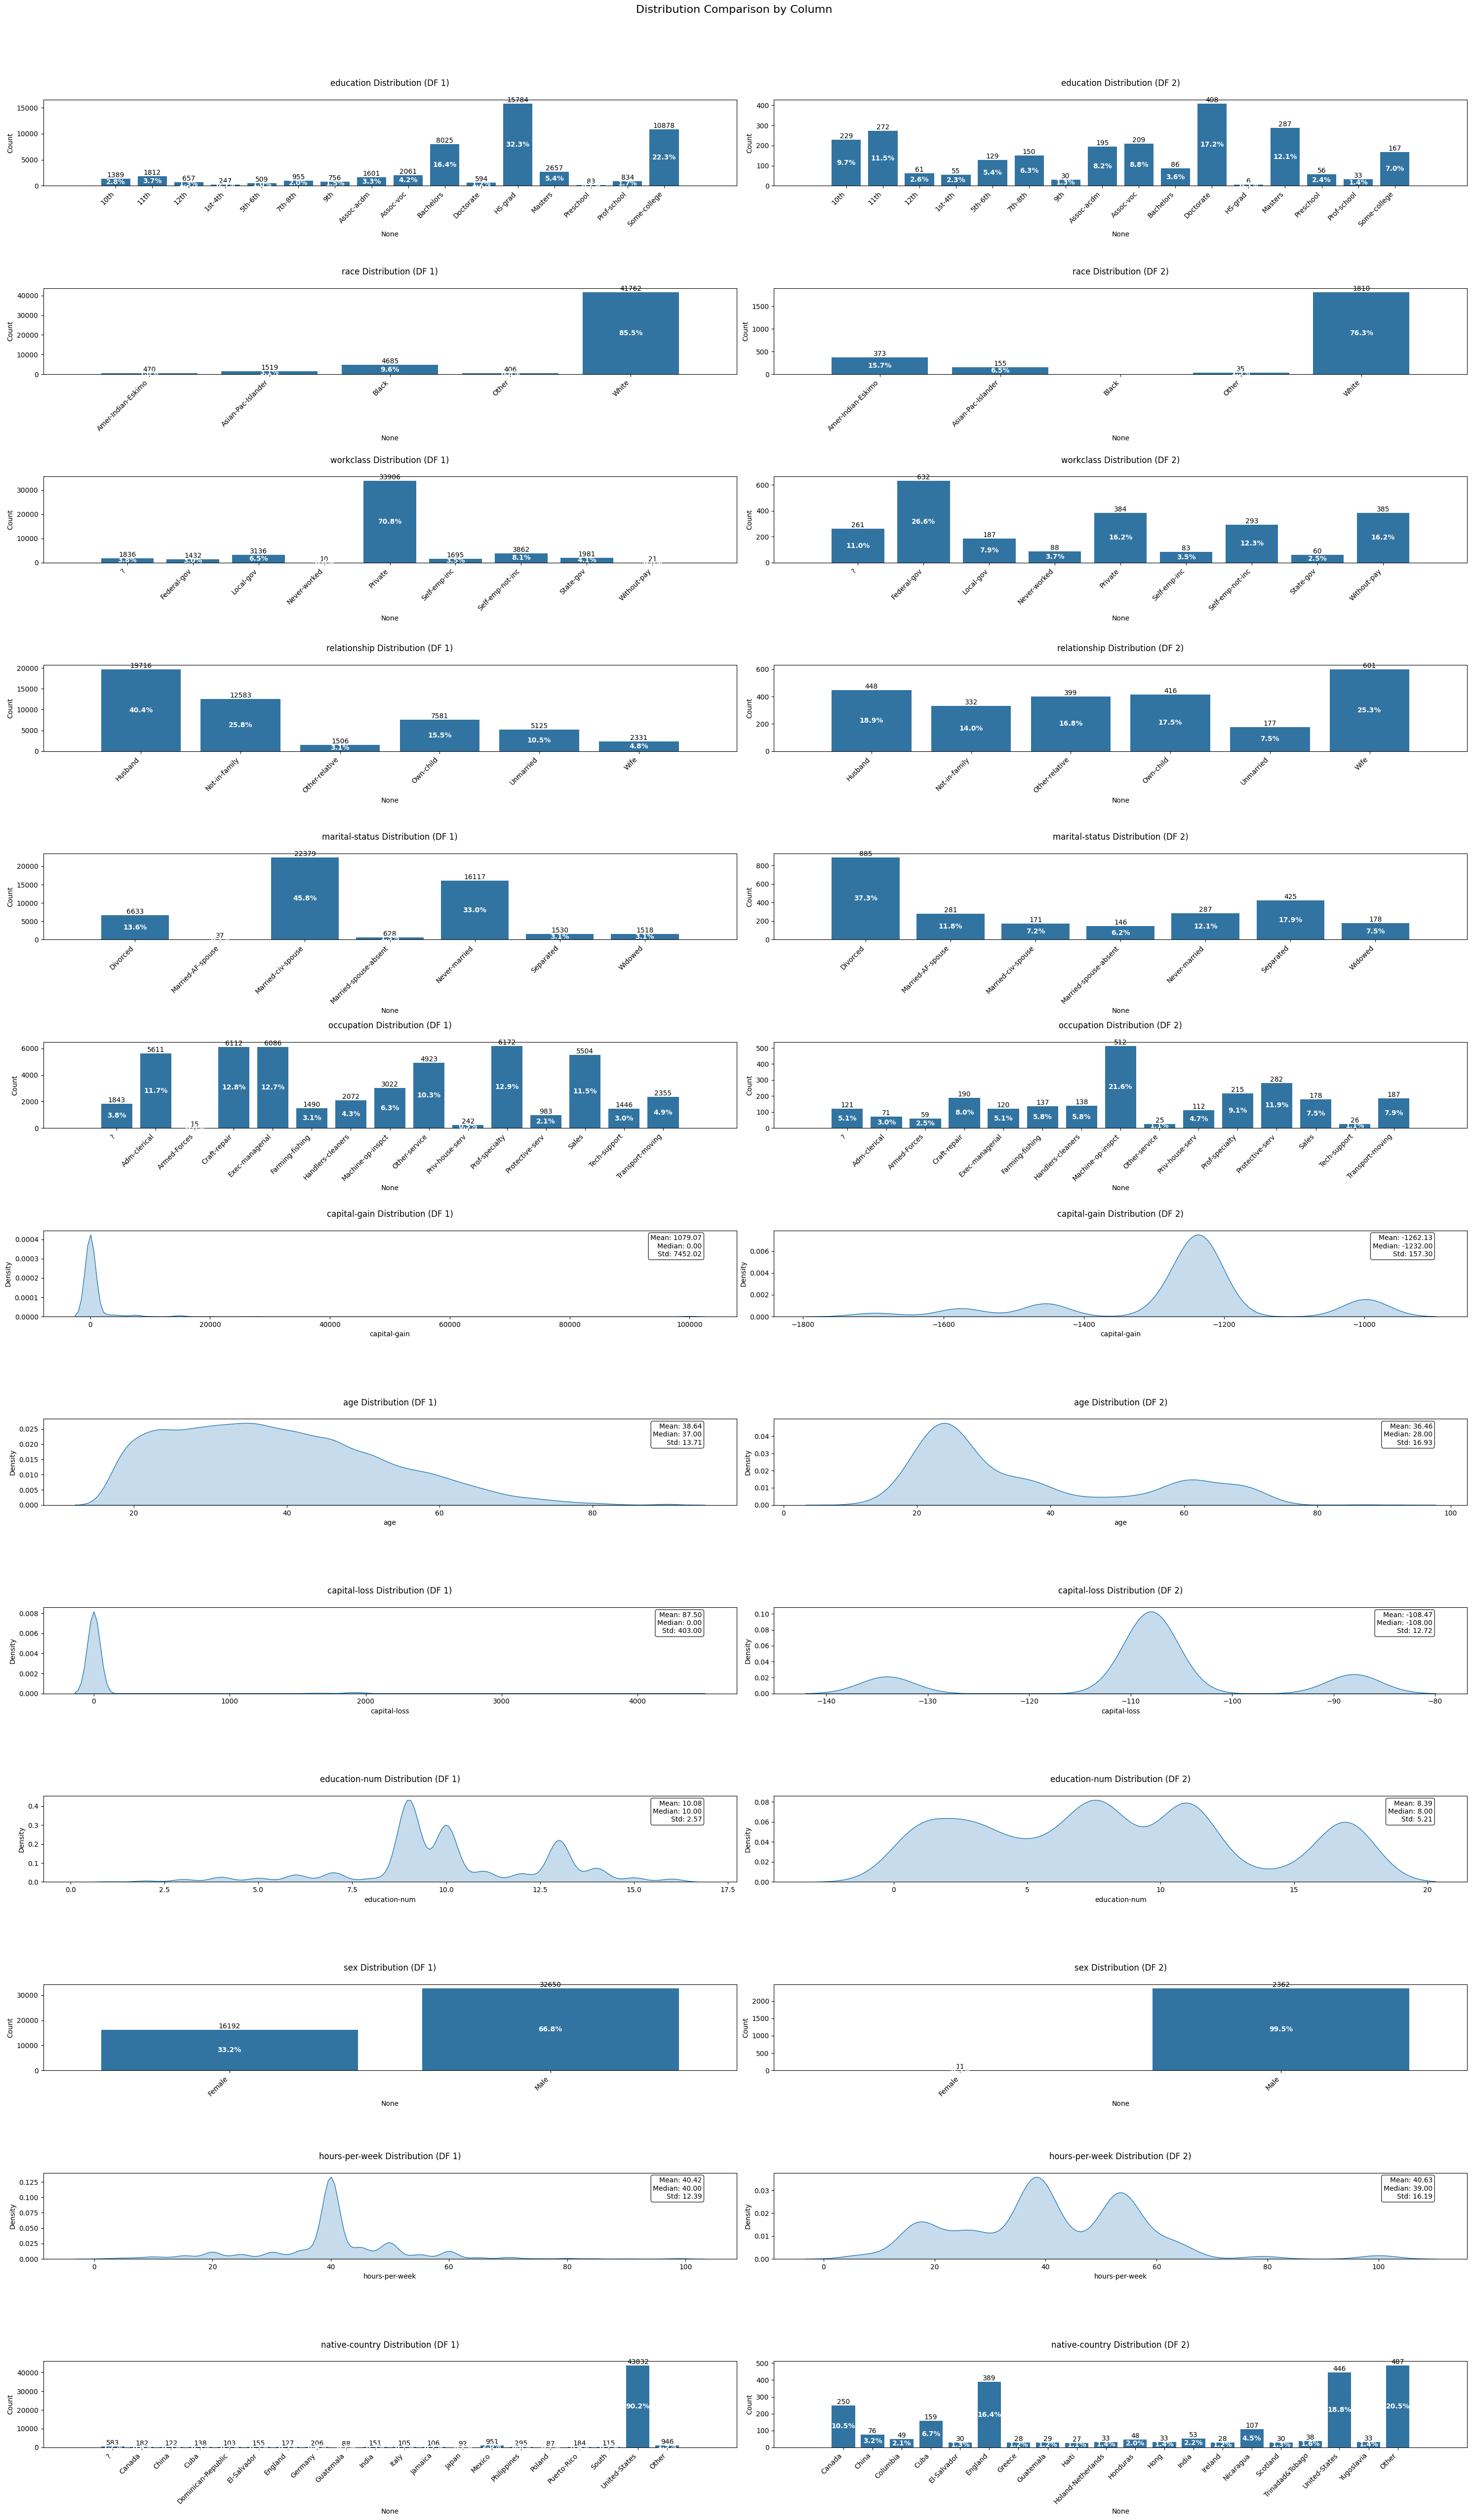

In [16]:
fig = plot_distributions_comparison(df1, df2, figsize=(30, 50))
plt.show()

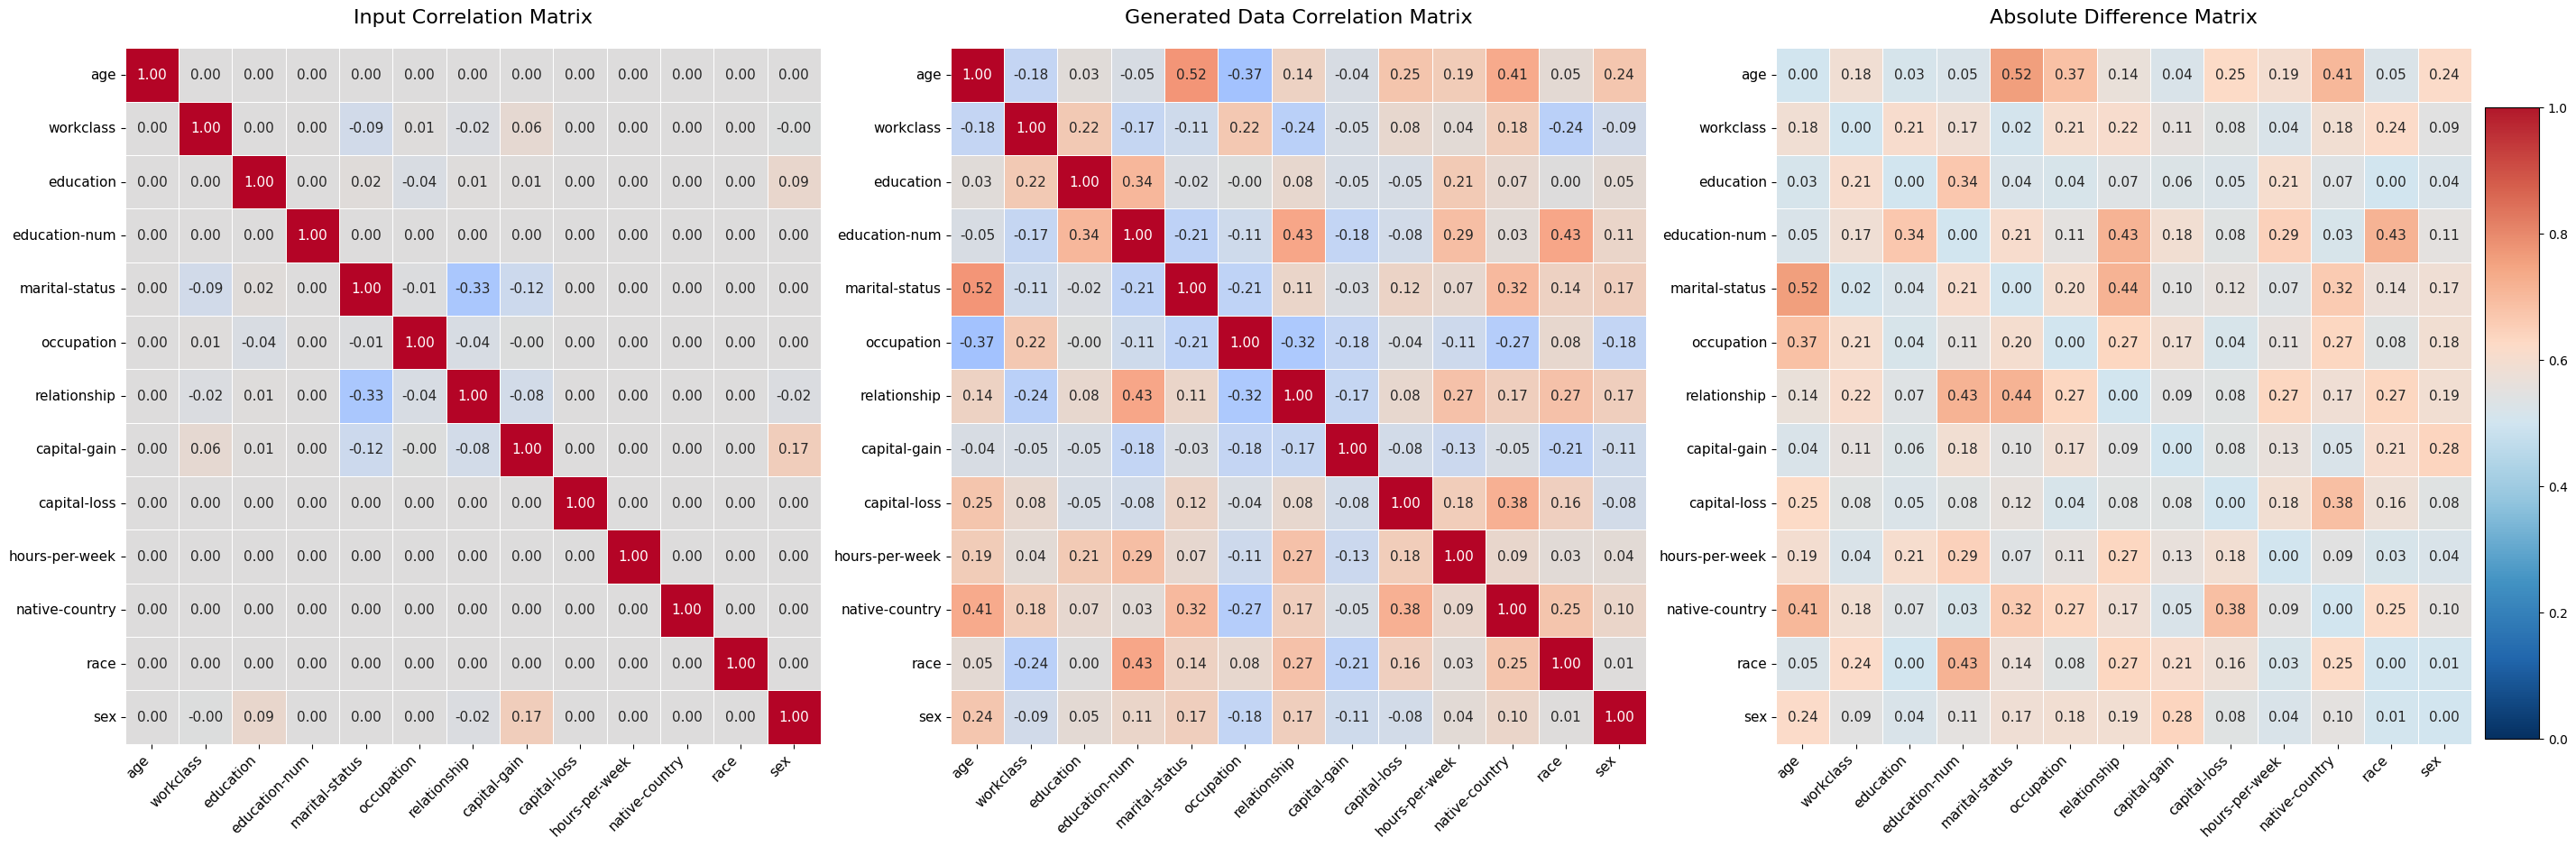


Matrix Similarity Metrics:
Mean absolute difference: 0.1496
Maximum absolute difference: 0.5177
Frobenius norm: 2.4957
Cosine similarity: 0.8186
Mean squared error: 0.0369
Correlation coefficient: 0.8049


In [15]:
plot_correlation_matrices(corr_matrix, data)

# German credit dataset

### Original dataset

In [27]:
print(statlog_german_credit_data.variables) 

           name     role         type     demographic  \
0    Attribute1  Feature  Categorical            None   
1    Attribute2  Feature      Integer            None   
2    Attribute3  Feature  Categorical            None   
3    Attribute4  Feature  Categorical            None   
4    Attribute5  Feature      Integer            None   
5    Attribute6  Feature  Categorical            None   
6    Attribute7  Feature  Categorical           Other   
7    Attribute8  Feature      Integer            None   
8    Attribute9  Feature  Categorical  Marital Status   
9   Attribute10  Feature  Categorical            None   
10  Attribute11  Feature      Integer            None   
11  Attribute12  Feature  Categorical            None   
12  Attribute13  Feature      Integer             Age   
13  Attribute14  Feature  Categorical            None   
14  Attribute15  Feature  Categorical           Other   
15  Attribute16  Feature      Integer            None   
16  Attribute17  Feature  Categ

In [23]:
statlog_german_credit_data = fetch_ucirepo(id=144)
df1 = statlog_german_credit_data['data']['original']
df1

,Attribute1,Attribute2,Attribute3,Attribute4,Attribute5,Attribute6,Attribute7,Attribute8,Attribute9,Attribute10,...,Attribute12,Attribute13,Attribute14,Attribute15,Attribute16,Attribute17,Attribute18,Attribute19,Attribute20,class
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,A14,12,A32,A42,1736,A61,A74,3,A92,A101,...,A121,31,A143,A152,1,A172,1,A191,A201,1
996,A11,30,A32,A41,3857,A61,A73,4,A91,A101,...,A122,40,A143,A152,1,A174,1,A192,A201,1
997,A14,12,A32,A43,804,A61,A75,4,A93,A101,...,A123,38,A143,A152,1,A173,1,A191,A201,1
998,A11,45,A32,A43,1845,A61,A73,4,A93,A101,...,A124,23,A143,A153,1,A173,1,A192,A201,2


In [29]:
schema, corr_matrix = generate_schema_from_dataframe(df1, protected_columns=['Attribute8', 'Attribute12'], outcome_column='Attribute20',
                                                     n_samples=50)

### Generated dataset

In [30]:
data = generate_data(
    correlation_matrix=corr_matrix,
    data_schema=schema,
    nb_groups=10,
    max_group_size=400,
    categorical_outcome=True,
    use_cache=False,
    corr_matrix_randomness=0.0)

print(f"Generated {len(data.dataframe)} samples in {data.nb_groups} groups")
print(f"Collisions: {data.collisions}")

df2 = decode_dataframe(data.dataframe, schema)
df2

Generating data: 100%|██████████| 10/10 [00:00<00:00, 12.60it/s]
Generated 1421 samples in 10 groups
Collisions: 0


,Attribute1,Attribute2,Attribute3,Attribute4,Attribute5,Attribute6,Attribute7,Attribute8,Attribute9,Attribute10,Attribute11,Attribute12,Attribute13,Attribute14,Attribute15,Attribute16,Attribute17,Attribute18,Attribute19,class
157,A14,28,A33,A45,7474,A65,A71,2,A91,A101,1,A121,18,A141,A152,1,A174,1,A192,2
95,A14,33,A31,A44,1841,A65,A72,2,A91,A101,1,A121,18,A141,A152,1,A174,1,A192,2
79,A14,45,A34,A48,2447,A62,A74,2,A91,A101,1,A121,19,A141,A152,1,A174,1,A192,2
158,A14,61,A30,A43,2583,A65,A71,2,A91,A101,1,A124,17,A141,A152,1,A174,1,A192,2
136,A14,8,A34,A43,214,A65,A75,2,A91,A101,1,A121,18,A141,A152,1,A174,1,A192,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
944,A13,38,A34,A44,1893,A65,A74,2,A93,A101,2,A121,17,A143,A152,2,A174,1,A191,2
948,A13,38,A34,A44,2312,A65,A75,2,A93,A101,1,A121,17,A143,A152,2,A174,1,A191,1
937,A13,38,A34,A45,2211,A65,A75,3,A92,A101,2,A121,18,A141,A152,2,A174,1,A192,1
946,A13,38,A34,A45,2936,A65,A72,2,A93,A101,3,A121,17,A143,A152,3,A174,1,A191,2


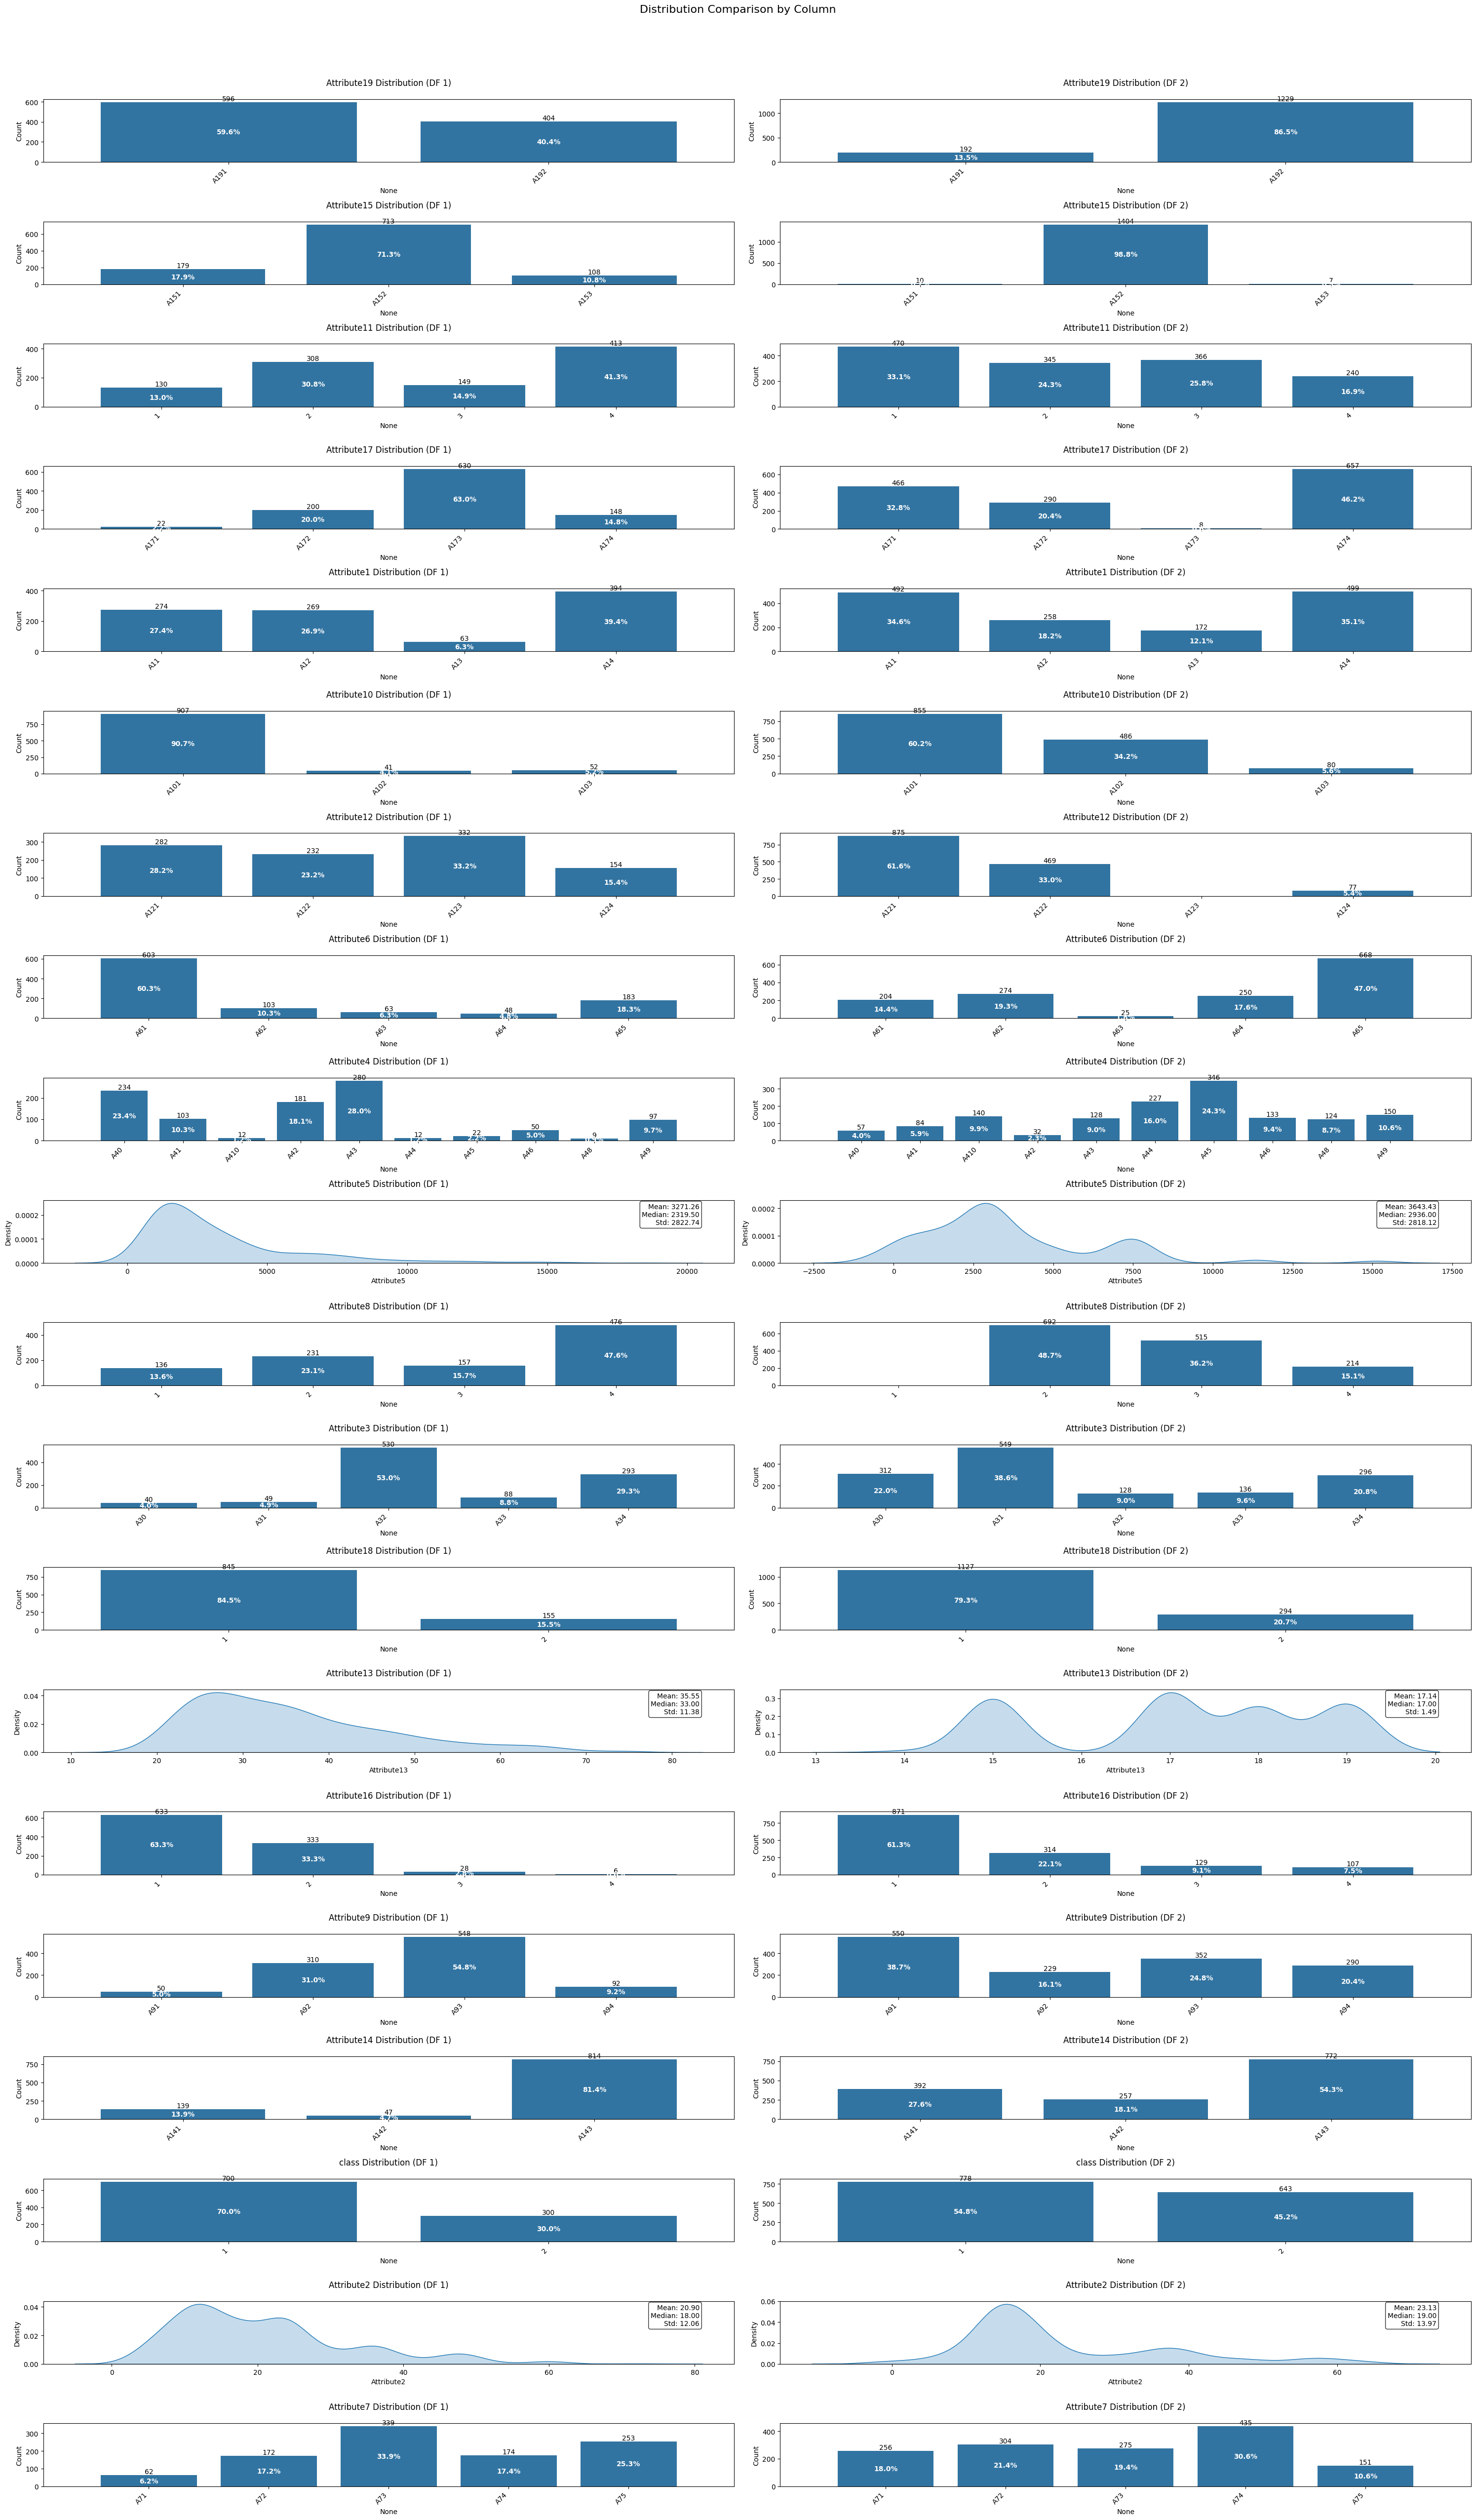

In [32]:
fig = plot_distributions_comparison(df1, df2, figsize=(30, 50))
plt.show()

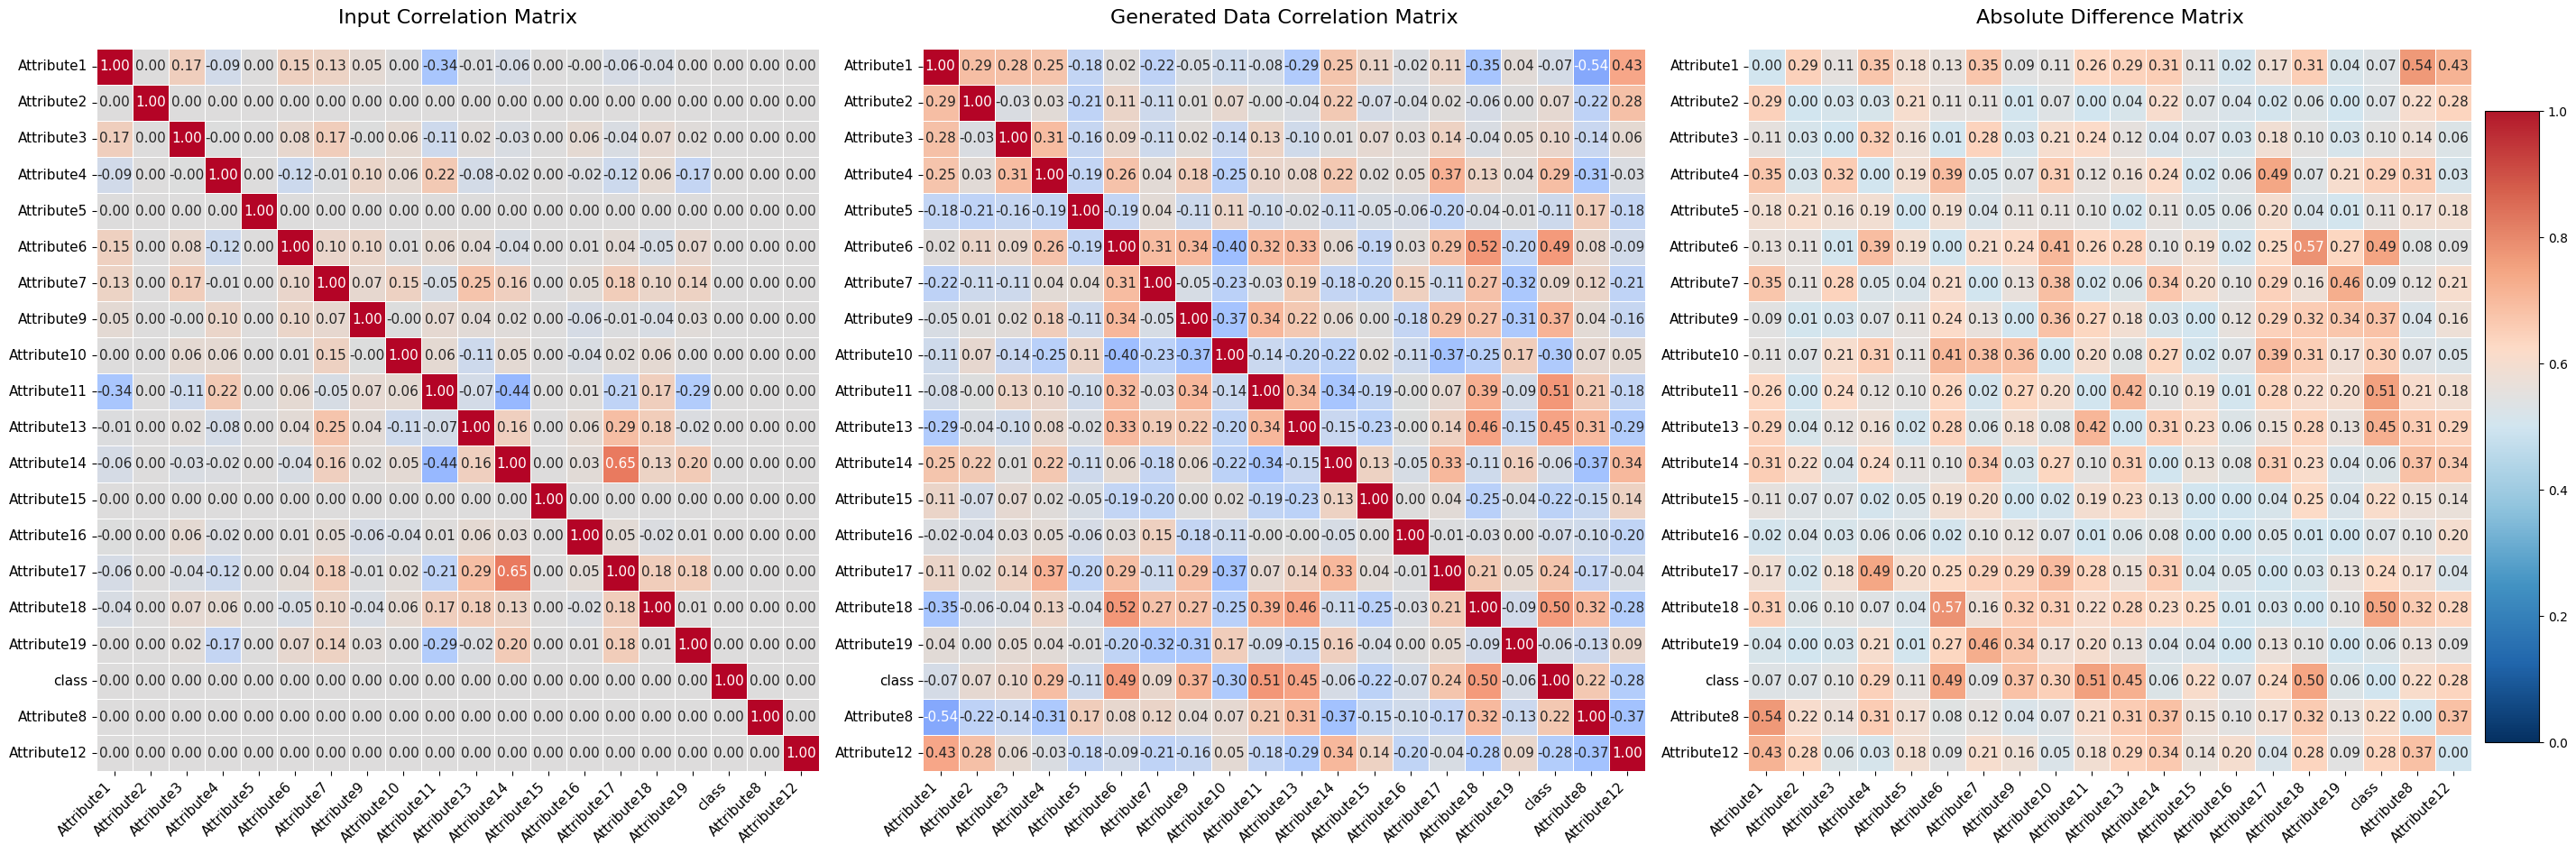


Matrix Similarity Metrics:
Mean absolute difference: 0.1659
Maximum absolute difference: 0.5674
Frobenius norm: 4.2410
Cosine similarity: 0.7184
Mean squared error: 0.0450
Correlation coefficient: 0.7045


In [33]:
plot_correlation_matrices(corr_matrix, data)
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=ac560f7a-a215-45b2-bdc4-8c0a3d83faaf' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>